In [377]:
import yfinance as yf
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from finta import TA
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import jaccard_score
import seaborn as sn
from tabulate import tabulate


In [378]:
WINDOW = 1 # number of rows to look ahead to see what the price did
FETCH_INTERVAL = "1h"  # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
INTERVAL = '1y'     # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
symbol = 'FB'      # Symbol of the desired stock
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'CCI', 'VORTEX']

In [379]:
data = yf.download(  # or pdr.get_data_yahoo(...
        tickers = symbol,


        period = INTERVAL,

        interval = FETCH_INTERVAL,

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',

        # adjust all OHLC automatically
        # (optional, default is False)
        # auto_adjust = True,

        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = True,

        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,

        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-02-04,205.200000,206.700000,205.200000,206.400000,206.400000,0
2020-02-04,206.400000,206.440000,206.250000,206.390000,206.390000,0
2020-02-04,206.180000,206.340000,206.000000,206.340000,206.340000,0
2020-02-04,206.340000,206.350000,206.000000,206.300000,206.300000,0
2020-02-04,206.290000,206.500000,204.700000,206.070000,206.070000,0
...,...,...,...,...,...,...
2021-02-03,268.234985,268.559998,266.950012,267.880005,267.880005,1246802
2021-02-03,267.869995,268.229889,266.679993,266.779999,266.779999,1244747
2021-02-03,266.799988,267.959991,266.559998,266.679993,266.679993,1387200


In [380]:
data.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
data.head(10)

,open,high,low,close,Adj Close,volume
Date,,,,,,
2020-02-04,205.200000,206.700000,205.200000,206.400000,206.400000,0
2020-02-04,206.400000,206.440000,206.250000,206.390000,206.390000,0
2020-02-04,206.180000,206.340000,206.000000,206.340000,206.340000,0
2020-02-04,206.340000,206.350000,206.000000,206.300000,206.300000,0
2020-02-04,206.290000,206.500000,204.700000,206.070000,206.070000,0
2020-02-04,206.010000,206.480000,204.190000,206.270000,206.270000,0
2020-02-04,206.470001,208.309998,205.202499,207.940002,207.940002,6050902
2020-02-04,207.950699,208.410004,207.229996,208.110703,208.110703,2213458
2020-02-04,208.100006,209.550003,208.089996,209.030197,209.030197,1970385


<AxesSubplot:xlabel='Date'>

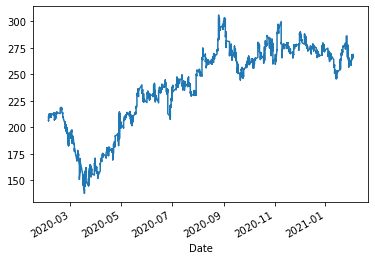

In [381]:
data['close'].plot()

In [382]:
def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """

    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = pd.concat([data, ind_data], axis=1)
    data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    # Also calculate moving averages for features
    data['ema50'] = data['close'] / data['close'].ewm(50).mean()
    data['ema21'] = data['close'] / data['close'].ewm(21).mean()
    data['ema15'] = data['close'] / data['close'].ewm(14).mean()
    data['ema5'] = data['close'] / data['close'].ewm(5).mean()

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()

    # Remove columns that won't be used as features
    del (data['open'])
    del (data['high'])
    del (data['low'])
    del (data['volume'])
    del (data['Adj Close'])

    return data

data = _get_indicator_data(data)

In [383]:
data

,close,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,20 period CCI,VIm,VIp,ema50,ema21,ema15,ema5,normVol
Date,,,,,,,,,,,,,,,,,,
2020-02-04,206.400000,NaN,0.000000,0.000000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,NaN
2020-02-04,206.390000,0.000000,-0.000224,-0.000125,NaN,0.000000e+00,NaN,NaN,NaN,NaN,66.666667,NaN,NaN,0.999976,0.999976,0.999977,0.999978,NaN
2020-02-04,206.340000,0.000000,-0.001836,-0.000826,NaN,0.000000e+00,NaN,NaN,NaN,NaN,-1.694915,NaN,NaN,0.999824,0.999827,0.999829,0.999840,NaN
2020-02-04,206.300000,0.000000,-0.003969,-0.001891,NaN,0.000000e+00,NaN,NaN,NaN,NaN,-9.053498,NaN,NaN,0.999726,0.999731,0.999736,0.999760,NaN
2020-02-04,206.070000,0.000000,-0.014196,-0.005551,NaN,0.000000e+00,NaN,NaN,NaN,NaN,-153.573377,NaN,NaN,0.998900,0.998919,0.998936,0.999023,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-03,267.880005,56.740414,0.807584,0.870919,93.377677,7.106224e+09,3.192893,0.080005,46.379635,0.273257,55.323461,0.985011,0.985457,1.003720,1.007169,1.006118,1.002376,0.994326
2021-02-03,266.779999,51.758043,0.714587,0.839653,87.859074,7.105184e+09,3.066099,-1.700001,41.509313,-0.011244,13.888412,0.990917,1.019685,0.999606,1.002895,1.001854,0.998549,0.993898
2021-02-03,266.679993,51.316859,0.625604,0.796843,52.984849,7.104082e+09,1.829479,-1.070007,37.162886,-0.418225,6.411374,0.975013,1.649392,0.999246,1.002405,1.001380,0.998479,1.088122


In [384]:
data.columns

Index(['close', '14 period RSI', 'MACD', 'SIGNAL', '14 period STOCH %K', 'MFV',
       '14 period ATR', 'MOM', '14 period MFI', 'ROC', '20 period CCI', 'VIm',
       'VIp', 'ema50', 'ema21', 'ema15', 'ema5', 'normVol'],
      dtype='object')

In [385]:
live_pred_data = data.iloc[-16:]
live_pred_data

,close,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,20 period CCI,VIm,VIp,ema50,ema21,ema15,ema5,normVol
Date,,,,,,,,,,,,,,,,,,
2021-02-02,266.810000,57.971033,1.278799,1.171498,89.582603,7.096361e+09,3.140577,2.620000,68.249375,0.789513,64.506759,0.943141,1.054358,1.000015,1.006325,1.006353,1.000644,0.000000
2021-02-03,267.800000,61.722199,1.285822,1.194362,94.638089,7.096361e+09,3.212005,1.829999,68.249375,1.312753,81.936182,0.907490,1.058041,1.003652,1.009597,1.009408,1.003628,0.000000
2021-02-03,268.480000,64.092795,1.330916,1.221673,98.110545,7.096361e+09,3.184862,0.809987,68.249375,1.623831,88.612950,0.903113,1.080739,1.006078,1.011602,1.011165,1.005142,0.000000
2021-02-03,267.750000,59.810408,1.292845,1.235907,94.382762,7.096361e+09,3.133434,-0.739899,68.249375,0.669248,70.313260,0.903347,1.085484,1.003277,1.008445,1.007850,1.002007,0.000000
2021-02-03,266.010000,51.054144,1.109480,1.210622,85.497362,7.096361e+09,3.129148,-1.785013,68.249375,-0.620172,12.078953,0.910062,1.061176,0.996821,1.001806,1.001213,0.996243,0.000000
2021-02-03,267.080000,55.380171,1.038532,1.176204,90.961372,7.096361e+09,2.974147,0.085005,54.975329,-0.525122,24.108965,0.982708,1.037706,1.000814,1.005569,1.004890,1.000209,0.000000
2021-02-03,265.680000,49.247039,0.859429,1.112849,83.812200,7.096361e+09,2.906291,-2.240013,44.633078,-0.789788,-5.571485,0.995330,0.995576,0.995654,1.000284,0.999647,0.995801,0.000000
2021-02-03,265.350006,47.900465,0.682988,1.026877,82.127069,7.100337e+09,3.072727,-1.649994,16.531615,-0.616112,-34.240741,1.007436,0.907714,0.994527,0.999085,0.998512,0.995466,4.504910
2021-02-03,266.559998,52.977572,0.633490,0.948199,89.263150,7.102109e+09,3.146499,-0.760002,31.299673,-0.507620,-2.412390,1.013782,0.932807,0.999080,1.003475,1.002860,1.000005,1.593204


In [386]:
def create_class_column(row):
    if row['close_shift']-row['close'] > 0.35:
        return 1
    if row['close_shift'] -row['close']< -0.35:
        return -1
    else:
        return 0

In [387]:
data['close_shift'] = data.shift(-WINDOW)['close']
data

,close,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,20 period CCI,VIm,VIp,ema50,ema21,ema15,ema5,normVol,close_shift
Date,,,,,,,,,,,,,,,,,,,
2020-02-04,206.400000,NaN,0.000000,0.000000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,NaN,206.390000
2020-02-04,206.390000,0.000000,-0.000224,-0.000125,NaN,0.000000e+00,NaN,NaN,NaN,NaN,66.666667,NaN,NaN,0.999976,0.999976,0.999977,0.999978,NaN,206.340000
2020-02-04,206.340000,0.000000,-0.001836,-0.000826,NaN,0.000000e+00,NaN,NaN,NaN,NaN,-1.694915,NaN,NaN,0.999824,0.999827,0.999829,0.999840,NaN,206.300000
2020-02-04,206.300000,0.000000,-0.003969,-0.001891,NaN,0.000000e+00,NaN,NaN,NaN,NaN,-9.053498,NaN,NaN,0.999726,0.999731,0.999736,0.999760,NaN,206.070000
2020-02-04,206.070000,0.000000,-0.014196,-0.005551,NaN,0.000000e+00,NaN,NaN,NaN,NaN,-153.573377,NaN,NaN,0.998900,0.998919,0.998936,0.999023,NaN,206.270000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-03,267.880005,56.740414,0.807584,0.870919,93.377677,7.106224e+09,3.192893,0.080005,46.379635,0.273257,55.323461,0.985011,0.985457,1.003720,1.007169,1.006118,1.002376,0.994326,266.779999
2021-02-03,266.779999,51.758043,0.714587,0.839653,87.859074,7.105184e+09,3.066099,-1.700001,41.509313,-0.011244,13.888412,0.990917,1.019685,0.999606,1.002895,1.001854,0.998549,0.993898,266.679993
2021-02-03,266.679993,51.316859,0.625604,0.796843,52.984849,7.104082e+09,1.829479,-1.070007,37.162886,-0.418225,6.411374,0.975013,1.649392,0.999246,1.002405,1.001380,0.998479,1.088122,267.000000


In [388]:
data['class_column'] = data.apply(create_class_column, axis=1)
data

,close,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,20 period CCI,VIm,VIp,ema50,ema21,ema15,ema5,normVol,close_shift,class_column
Date,,,,,,,,,,,,,,,,,,,,
2020-02-04,206.400000,NaN,0.000000,0.000000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,NaN,206.390000,0
2020-02-04,206.390000,0.000000,-0.000224,-0.000125,NaN,0.000000e+00,NaN,NaN,NaN,NaN,66.666667,NaN,NaN,0.999976,0.999976,0.999977,0.999978,NaN,206.340000,0
2020-02-04,206.340000,0.000000,-0.001836,-0.000826,NaN,0.000000e+00,NaN,NaN,NaN,NaN,-1.694915,NaN,NaN,0.999824,0.999827,0.999829,0.999840,NaN,206.300000,0
2020-02-04,206.300000,0.000000,-0.003969,-0.001891,NaN,0.000000e+00,NaN,NaN,NaN,NaN,-9.053498,NaN,NaN,0.999726,0.999731,0.999736,0.999760,NaN,206.070000,0
2020-02-04,206.070000,0.000000,-0.014196,-0.005551,NaN,0.000000e+00,NaN,NaN,NaN,NaN,-153.573377,NaN,NaN,0.998900,0.998919,0.998936,0.999023,NaN,206.270000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-03,267.880005,56.740414,0.807584,0.870919,93.377677,7.106224e+09,3.192893,0.080005,46.379635,0.273257,55.323461,0.985011,0.985457,1.003720,1.007169,1.006118,1.002376,0.994326,266.779999,-1
2021-02-03,266.779999,51.758043,0.714587,0.839653,87.859074,7.105184e+09,3.066099,-1.700001,41.509313,-0.011244,13.888412,0.990917,1.019685,0.999606,1.002895,1.001854,0.998549,0.993898,266.679993,0
2021-02-03,266.679993,51.316859,0.625604,0.796843,52.984849,7.104082e+09,1.829479,-1.070007,37.162886,-0.418225,6.411374,0.975013,1.649392,0.999246,1.002405,1.001380,0.998479,1.088122,267.000000,0


In [389]:
# Class divide
data['class_column'].value_counts()

 1    1418
 0    1386
-1    1339
Name: class_column, dtype: int64

In [390]:
del (data['close'])
data = data.dropna()
data

,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,20 period CCI,VIm,VIp,ema50,ema21,ema15,ema5,normVol,close_shift,class_column
Date,,,,,,,,,,,,,,,,,,,
2020-02-04,85.534862,0.476379,0.341800,90.015515,1.827404e+07,1.546967,3.890000,89.077600,1.754386,99.143895,0.830544,1.211474,1.008408,1.007594,1.006930,1.004081,0.000000,209.800000,0
2020-02-04,81.181085,0.472696,0.368737,87.519417,1.827404e+07,1.569110,3.530000,89.077600,1.696558,87.122402,0.821100,1.153863,1.007084,1.006232,1.005544,1.002730,0.000000,212.030000,1
2020-02-05,89.331673,0.602024,0.416470,100.000000,1.827404e+07,1.700539,4.089998,89.077600,2.892221,141.525646,0.764360,1.156673,1.016548,1.015498,1.014642,1.011026,0.000000,212.300000,0
2020-02-05,89.901937,0.710702,0.476396,92.054484,1.827404e+07,1.744825,4.189297,89.077600,2.923353,152.414005,0.735135,1.201003,1.016656,1.015424,1.014419,1.010159,0.000000,212.200000,0
2020-02-05,88.025182,0.779162,0.537834,90.919410,1.827404e+07,1.631967,3.169803,89.077600,2.048667,127.438139,0.754022,1.269176,1.015150,1.013772,1.012653,1.008004,0.000000,212.250000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-03,58.523787,0.802536,0.886753,95.259008,7.105591e+09,3.192886,1.445005,43.038956,0.349770,104.514498,0.962416,1.013870,1.005200,1.008924,1.007967,1.004256,1.161489,267.880005,-1
2021-02-03,56.740414,0.807584,0.870919,93.377677,7.106224e+09,3.192893,0.080005,46.379635,0.273257,55.323461,0.985011,0.985457,1.003720,1.007169,1.006118,1.002376,0.994326,266.779999,-1
2021-02-03,51.758043,0.714587,0.839653,87.859074,7.105184e+09,3.066099,-1.700001,41.509313,-0.011244,13.888412,0.990917,1.019685,0.999606,1.002895,1.001854,0.998549,0.993898,266.679993,0


In [391]:
now = datetime.now()
data.to_csv(f'../data/preprocess/{symbol}_{now.strftime("%d_%m_%Y %H_%M_%S")}.csv', index=True)
live_pred_data.to_csv(f'../data/preprocess/{symbol}_Live_{now.strftime("%d_%m_%Y %H_%M_%S")}.csv', index=True)

In [392]:
def _train_random_forest(X_train, y_train, X_test, y_test):

    """
    Function that uses random forest classifier to train the model
    :return:
    """

    # Create a new random forest classifier
    rf = RandomForestClassifier()

    # Dictionary of all values we want to test for n_estimators
    params_rf = {'n_estimators': [110,130,140,150,160,180,200]}

    # Use gridsearch to test all values for n_estimators
    rf_gs = GridSearchCV(rf, params_rf, cv=5)

    # Fit model to training data
    rf_gs.fit(X_train, y_train)

    # Save best model
    rf_best = rf_gs.best_estimator_

    # Check best n_estimators value
    # print(rf_gs.best_params_)

    # prediction = rf_best.predict(X_test)
    #
    # print(classification_report(y_test, prediction))
    # print(confusion_matrix(y_test, prediction))

    return rf_best

def cross_Validation(data):

    # Split data into equal partitions of size len_train

    num_train = 50 # Increment of how many starting points (len(data) / num_train  =  number of train-test sets)
    len_train = 100 # Length of each train-test set

    # Lists to store the results from each model
    rf_RESULTS = []

    i = 0
    while True:

        # Partition the data into chunks of size len_train every num_train days
        df = data.iloc[i * num_train : (i * num_train) + len_train]
        i += 1
        print(i * num_train, (i * num_train) + len_train)

        if len(df) < 40:
            break

        y = df['class_column']
        features = [x for x in df.columns if x not in ['class_column']]
        X = df[features]

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 7 * len(X) // 10,shuffle=False)

        rf_model = _train_random_forest(X_train, y_train, X_test, y_test)

        rf_prediction = rf_model.predict(X_test)

        # print('rf prediction is ', rf_prediction)
        # print('truth values are ', y_test.values)

        rf_accuracy = accuracy_score(y_test.values, rf_prediction)

        print('accuracy', rf_accuracy)
        rf_RESULTS.append(rf_accuracy)


    print('RF Accuracy = ' + str( sum(rf_RESULTS) / len(rf_RESULTS)))


cross_Validation(data)

50 150
accuracy 0.43333333333333335
100 200
accuracy 0.6666666666666666
150 250
accuracy 0.3
200 300
accuracy 0.6
250 350
accuracy 0.43333333333333335
300 400
accuracy 0.43333333333333335
350 450
accuracy 0.43333333333333335
400 500
accuracy 0.5
450 550
accuracy 0.36666666666666664
500 600
accuracy 0.43333333333333335
550 650
accuracy 0.4
600 700
accuracy 0.3
650 750
accuracy 0.3333333333333333
700 800
accuracy 0.4666666666666667
750 850
accuracy 0.26666666666666666
800 900
accuracy 0.2
850 950
accuracy 0.23333333333333334
900 1000
accuracy 0.3
950 1050
accuracy 0.36666666666666664
1000 1100
accuracy 0.3333333333333333
1050 1150
accuracy 0.1
1100 1200
accuracy 0.23333333333333334
1150 1250
accuracy 0.3
1200 1300
accuracy 0.4
1250 1350
accuracy 0.3
1300 1400
accuracy 0.36666666666666664
1350 1450
accuracy 0.26666666666666666
1400 1500
accuracy 0.36666666666666664
1450 1550
accuracy 0.16666666666666666
1500 1600
accuracy 0.4
1550 1650
accuracy 0.3333333333333333
1600 1700
accuracy 0.2
16

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
